# Explaining Deep Learning Models
## CHAPTER 07 - *Practical exposure of using SHAP in ML*

From **Applied Machine Learning Explainability Techniques** by [**Aditya Bhattacharya**](https://www.linkedin.com/in/aditya-bhattacharya-b59155b6/), published by **Packt**

### Objective

The goal of this notebook is to explore model explainability of deep learning image classification models using SHAP. Please check out *Chapter 7 - Practical exposure of using SHAP in ML* for other interesting approaches of using SHAP in practice.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"

### Installing the modules

#### ** optimized **

In [2]:
# intel-tensorflow==2.9.1
# intel-python==3.9.12,  intel-tensorflow==2.9.1, numba-dpex==0.18.1, dpctl==0.13.0
# shap @ git+https://github.com/slundberg/shap@v0.41.0
from explainer.explainers import feature_attributions_explainer, metrics_explainer

#### ** non-optimized **

In [3]:
%%script false --no-raise-error
# intel-python==3.9.12, tensorflow==2.9.1
from explainer.explainers import shap_explainer

### Loading the modules

In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import json

import shap
print(f"Tensorflow version {tf.__version__} Shap version {shap.__version__}")

Tensorflow version 2.9.1 Shap version 0.41.0


In [5]:
import tensorflow.compat.v1.keras.backend as K
tf.compat.v1.disable_eager_execution()
print('Disable Eager Execution for SHAP to work')

Disable Eager Execution for SHAP to work


## Using Gradient Explainers in SHAP

### Loading the dataset

We will choose an image from SHAP datasets.

In [6]:
X,y = shap.datasets.imagenet50(resolution=224)
inference_image = X[[46]] 

### Loading the model

In [7]:
model = VGG19(weights='imagenet') # Let's use VGG19 as our model

2022-10-18 19:18:03.758812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=1
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=768
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=1
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defin

Gradient explainer helps to map the gradient flow of intermediate layers of a Deep Learning model to explain the working of the model. Let's choose layer 10 for this example.

In [8]:
layer_num = 10 # Let's analyze the 10th layer

In [9]:
# explain how the input to the 10th layer of the model explains the top two classes
def map2layer(x, layer):
    '''
    Source : https://github.com/slundberg/shap
    '''
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

### SHAP Explainability

#### ** optimized **

In [11]:
pstats = metrics_explainer['pstats']
??pstats

Signature: pstats(command)
Source:   
def pstats(command):
  """
     Executes cProfile.run and saves the results in the PStats class as panda DataFrames. 
     Two DataFrames are stored - A summary and a report which call PStats.summary and PStats.report respectively.

     Args:
       command: command to run

     Returns:
       PStats: this class provides summary and report methods to display the DataFrames

     Reference:
       https://docs.python.org/3/library/profile.html
  """
  return PStats(command)
File:      ~/Github/intel-innersource/frameworks.ai.explainable-ai/explainer/explainer/explainers/metrics_explainer/metrics_explainer.py
Type:      function


In [12]:
# intel-python,  intel-tensorflow, numba-dpex, dpctl
model_input = (model.layers[layer_num].input, model.layers[-1].output)
pstats = metrics_explainer['pstats']('explainer = shap.GradientExplainer(model_input, map2layer(X, layer_num), local_smoothing=0)')
pstats.summary
pstats.report

,function calls,time
0,1671514,4.121


,ncalls,tottime,percall,cumtime,percall,filename:lineno(function)
0,1,1.518,1.518,1.518,1.518,method tensorflow.python.client._pywrap_tf_ses...
1,69782,0.360,0.000,0.360,0.000,method posix.lstat}
2,80,0.323,0.004,2.518,0.031,inspect.py:727(getmodule)
3,69788,0.284,0.000,0.463,0.000,posixpath.py:71(join)
4,5510,0.237,0.000,1.277,0.000,posixpath.py:397(_joinrealpath)
...,...,...,...,...,...,...
337,1,0.000,0.000,0.000,0.000,method builtins.issubclass}
338,1,0.000,0.000,0.000,0.000,module_wrapper.py:62(<genexpr>)
339,,None,None,None,None,None
340,,None,None,None,None,None


In [13]:
#%%script false --no-raise-error
# intel-python,  intel-tensorflow, numba-dpex, dpctl
# pstats = metrics_explainer['pstats']('shap_values, ind = explainer.shap_values(map2layer(inference_image, layer_num), ranked_outputs=4)')
# pstats.summary
# pstats.report
shap_values, ind = explainer.shap_values(map2layer(inference_image, layer_num), ranked_outputs=4)

In [14]:
# load the ImageNet class names
def load_imagenet_classes(url, ind):
    from urllib.request import urlopen
    import json
    import numpy as np
    response = urlopen(url)
    json_data = response.read().decode('utf-8')
    classes = json.loads(json_data)    
    class_names = np.vectorize(lambda x: classes[str(x)][1])(ind)
    return classes, class_names

url='https://raw.githubusercontent.com/WZMIAOMIAO/deep-learning-for-image-processing/master/pytorch_classification/mini_imagenet/imagenet_class_index.json'
imagenet_classes, class_names = load_imagenet_classes(url, ind)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


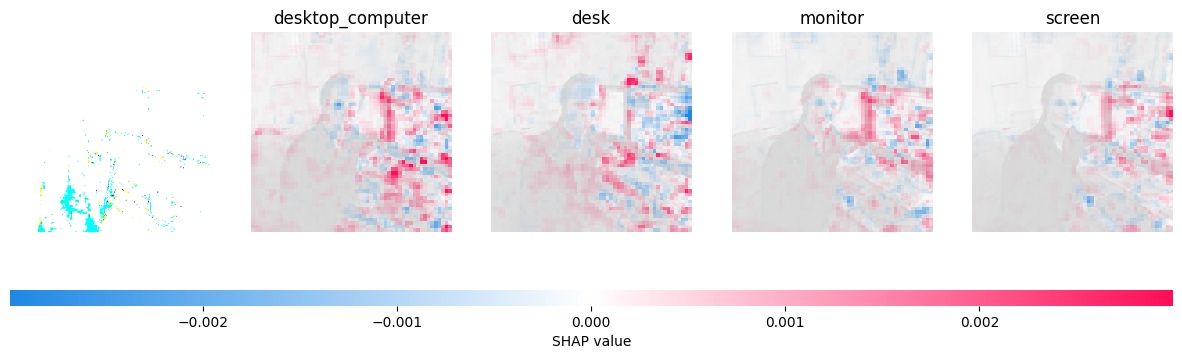

In [15]:
# plot the explanations
shap.image_plot(shap_values, inference_image, class_names)

From the above image, we can clearly see that based on the regions highlighted by the SHAP values how the model prediction is changing. When the model predicted the outcome as desktop computer, the region around the computer monitor keyboard and the desk got highlighted. Please observe that the man in the picture did not get highlighted. That is why the model did not predict the outcome as a man or human-being. Similarly, if you see that other possible predictions of desk monitor and screen, accordingly the different regions of the images are highlighted. This does provide a good explanation for the model outcome.

## Using Deep Explainers in SHAP

Now, let's use Deep Explainers in SHAP for Deep Learning models. But let's train a model from scratch in this example, instead of using pre-trained model architectures.

### Reloading the modules for this new section.

In [16]:
%%script false --no-raise-error

# load package
import shap
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import cv2

### Preparing the data

In [17]:
%%script false --no-raise-error

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [18]:
%%script false --no-raise-error

x_train = x_train.reshape(50000, 32, 32, 3).astype("float32") / 255
x_test = x_test.reshape(10000, 32, 32, 3).astype("float32") / 255
y_train = y_train.reshape(50000,)
y_test = y_test.reshape(10000,)

### Define the model

In [19]:
%%script false --no-raise-error

# define the model architecture
inputs = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [20]:
%%script false --no-raise-error

# compile the model
model.compile(
      loss= 'sparse_categorical_crossentropy',
      optimizer= 'Adam',
      metrics=['sparse_categorical_accuracy']
  )
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 15)

From the model scores, we can see that our model has a good training accuracy, but not so good validation accuracy, indicating that the model is clearly over-fitting

In [21]:
%%script false --no-raise-error

model.save('models/convo_model')

In [22]:
%%script false --no-raise-error

reconstructed_model = keras.models.load_model("models/convo_model")

In [23]:
%%script false --no-raise-error

# Classes in CIFAR-10 data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [24]:
%%script false --no-raise-error

# Source : https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16
# Fetching an image for each of CIFAR-10 class
images_dict = dict()
for ind, label in enumerate(y_train):
    if len(images_dict)==10:
        break
    if label not in images_dict.keys():
        images_dict[label] = x_train[ind].reshape((32, 32,3))
images_dict = dict(sorted(images_dict.items()))

In [25]:
%%script false --no-raise-error

# Fetching an image for each of CIFAR-10 class for test set
x_test_dict = dict()
for ind, label in enumerate(y_test):
    if len(x_test_dict)==10:
        break
    if label not in x_test_dict.keys():
        x_test_dict[label] = x_test[ind]

# sorting
sample_x_test = [x_test_dict[i] for i in sorted(x_test_dict)]
sample_x_test = np.asarray(sample_x_test)

In [26]:
%%script false --no-raise-error

# Checking the predictions
predictions = model.predict(sample_x_test)
predicted_class = np.argmax(predictions, axis=1)

In [27]:
%%script false --no-raise-error

confusionmatrix = metrics_explainer['confusionmatrix']
confusionmatrix.__doc__
#confusionmatrix(sample_x_text, predictions, class_names)

In [28]:
%%script false --no-raise-error

# Source : https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16
# plot actual and predicted class
def plot_actual_predicted(images, pred_classes):
    fig, axes = plt.subplots(2, 5, figsize=(16, 6))
    fig.tight_layout()
    axes = axes.flatten()
    ax = axes[0]
    # plot image
    for k,v in images.items():
        ax = axes[k]
        ax.imshow(cv2.resize(v, (512,512)), cmap=plt.cm.binary)
        ax.set_title(f"Original: %s \nPredicted: %s" % (class_names[k], class_names[pred_classes[k]]))
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

Future exception was never retrieved
future: <Future finished exception=BrokenPipeError(32, 'Broken pipe')>
Traceback (most recent call last):
  File "/home/kdkasrav/.conda/envs/xai-oneapi-aikit/lib/python3.9/asyncio/unix_events.py", line 665, in write
    n = os.write(self._fileno, data)
BrokenPipeError: [Errno 32] Broken pipe


In [29]:
%%script false --no-raise-error

plot_actual_predicted(images_dict, predicted_class)

### SHAP Explainability

Now, we will use SHAP Deep Explainers to explain our model. First we will need to create a background set for SHAP and then compute Shapley values using Deep SHAP and visualize the same.

In [30]:
%%script false --no-raise-error

# Setting the backgroud for shap
background = x_train[np.random.choice(len(x_train), 1000, replace=False)]

# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)

# Computing the shap values
shap_values = explainer.shap_values(sample_x_test)

In [31]:
%%script false --no-raise-error

# Prepare the labels for display
labels = []
for i in range(10):
    labels.append(class_names)

In [32]:
%%script false --no-raise-error

plt.figure(figsize=(16, 12))
shap.image_plot(shap_values, sample_x_test, labels, labelpad=2)

## Final Thoughts

It was interesting to see how regions highlighted by SHAP values in red was actually related to the prediction class. I recommend looking at other tutorial examples provided by SHAP at https://github.com/slundberg/shap/tree/master/notebooks/image_examples and https://github.com/slundberg/shap/tree/master/notebooks/text_examples for applying SHAP with deep learning models trained on image and text data.

## Reference

1. SHAP GitHub Project - https://github.com/slundberg/shap
2. SHAP Documentations - https://shap.readthedocs.io/en/latest/index.html
3. SHAP Image Explainers - https://github.com/slundberg/shap/tree/master/notebooks/image_examples/image_classification
4. DeepExplainer Reference - "Deep Learning Model Interpretation Using SHAP" - https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16
4. Some of the utility functions and code are taken from the GitHub Repository of the author - Aditya Bhattacharya https://github.com/adib0073